In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain, read_eqdsk
from omfit_classes.omfit_eqdsk import OMFITgeqdsk


### Helpers

In [2]:
mu0 = 4 * np.pi * 10**-7

def estore_from_approx_beta_poloidal(Ip, beta, R0):
    return np.power(Ip,2)*beta*R0*3.0/8.0*mu0

from omfit_classes.omfit_eqdsk import boundaryShape

### Build machine

In [3]:
r,z,zeff= boundaryShape(kapu = 1.65, kapl = 1.65, delu = -0.4, dell = -0.4, zetail = -.2, zetaiu = -.2, zetaou = 0, zetaol = 0, a = 0.35, eps = 0.35/0.8, zoffset = 0, upnull = False, lonull = False, npts = 8)
vv_pts = np.column_stack((r,z))
coils = {
    'CS0': {'rc': 0.375, 'zc': -.54, 'w': 0.05, 'h': 0.35},
    'CS1': {'rc': 0.375, 'zc': 0, 'w': 0.05, 'h': 0.7},
    'CS2': {'rc': 0.375, 'zc': .54, 'w': 0.05, 'h': 0.35},

    'EF0U': {'rc': .588, 'zc': 0.53, 'w': 0.15, 'h': 0.15},
    'EF1U': {'rc': 1.1, 'zc': 0.74, 'w': 0.15, 'h': 0.15},
    'EF2U': {'rc': 1.25, 'zc': 0.6, 'w': 0.15, 'h': 0.15},
    'EF3U': {'rc': 1.7, 'zc': 0.3, 'w': .2, 'h': .2},

    'EF0L': {'rc': .588, 'zc': -0.53, 'w': 0.15, 'h': 0.15},
    'EF1L': {'rc': 1.1, 'zc': -0.74, 'w': 0.15, 'h': 0.15},
    'EF2L': {'rc': 1.25, 'zc': -0.6, 'w': 0.15, 'h': 0.15},
    'EF3L': {'rc': 1.7, 'zc': -0.3, 'w': .2, 'h': .2},
  
}

In [4]:
## Define mesh resolution in each region
plasma_resolution = 0.03
coil_resolution = 0.03
vv_resolution = 0.03
vac_resolution = 0.075

In [5]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')      # Define the bounding region
gs_mesh.define_region('plasma',plasma_resolution,'plasma')  # Define the plasma region and resolution
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

In [6]:
# Define vaccum vessel geometry
gs_mesh.add_polygon(vv_pts,'plasma',parent_name='air')             # Define the shape of the limiter
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

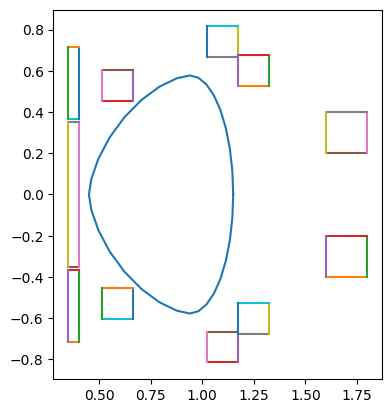

In [7]:
## Plot geometry
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

In [8]:
#Create mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 444
  # of unique segments  = 49
Generating mesh:
  # of points  = 2555
  # of cells   = 5000
  # of regions = 13


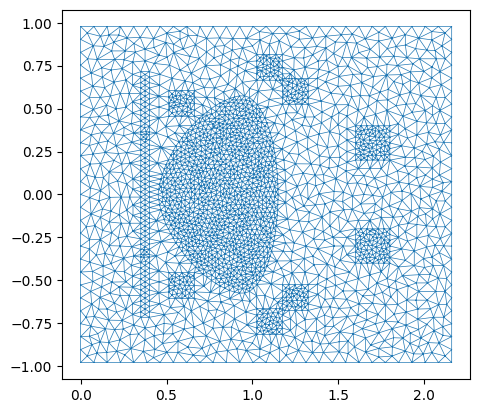

In [9]:
# Plot mesh
fig, ax = plt.subplots()
plt.gca().set_aspect(aspect = 1)
ax.triplot(mesh_pts[:,0],mesh_pts[:,1], lw = 0.5)

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.225E+00
    # of points  =    2555
    # of edges   =    7554
    # of cells   =    5000
    # of boundary points =     108
    # of boundary edges  =     108
    # of boundary cells  =     108
  Resolution statistics:
    hmin =  1.000E-02
    hrms =  4.691E-02
    hmax =  1.125

Saving EQDSK file
 "none"
Flux surfaces from 600x600 gEQDSK
Levels based on psi ...
Grid diagonal resolution: 0.0024700536672286875 [m]
Cropping tables ...
Find magnetic axis ...
Find separatrix ...
Tracing flux surfaces ...
  > Took 0:00:01.702778
Find Br, Bz, F on flux surfaces ...
  > Took 0:00:01.009929
Flux surface averaging ...
  > Took 0:00:01.272547
Geometric quantities ...
  > Took 0:00:02.877533
#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#------------------------------------

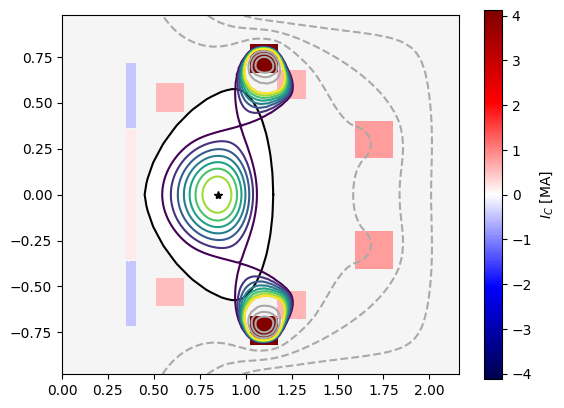

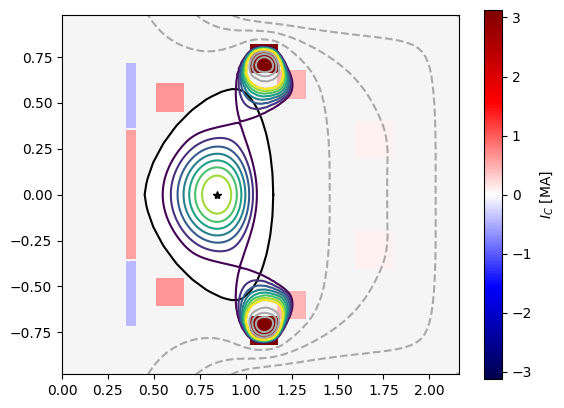

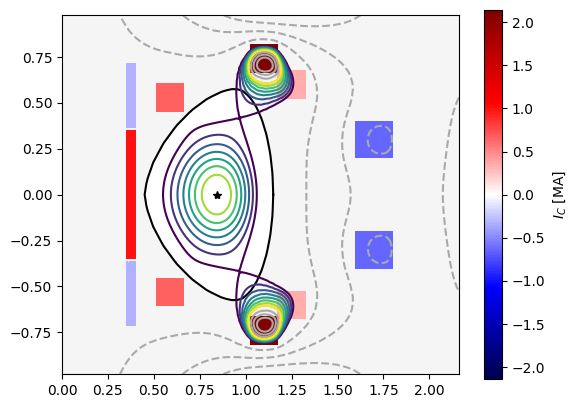

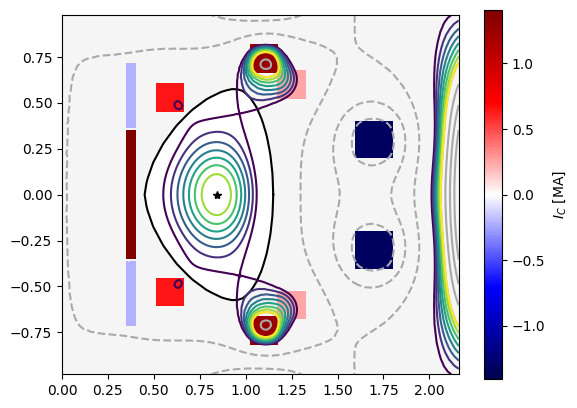

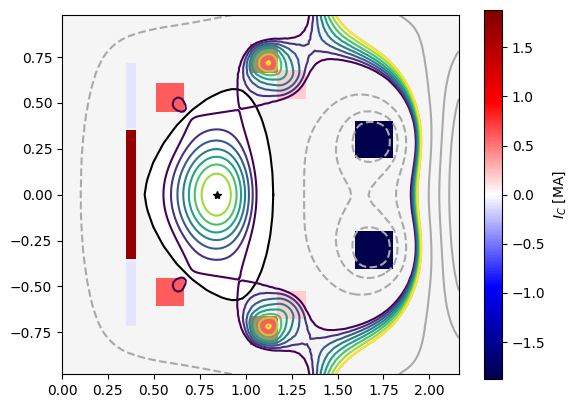

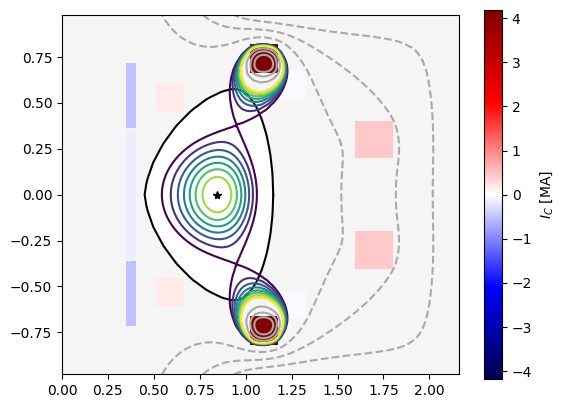

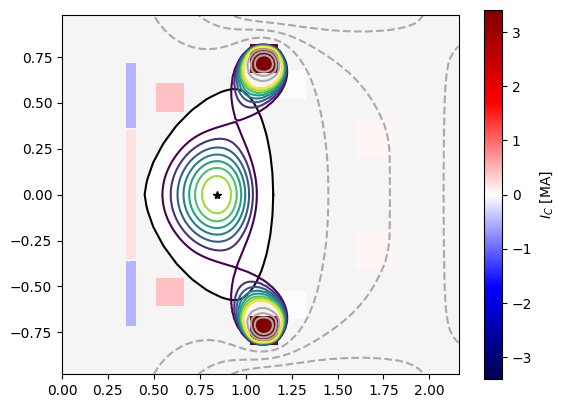

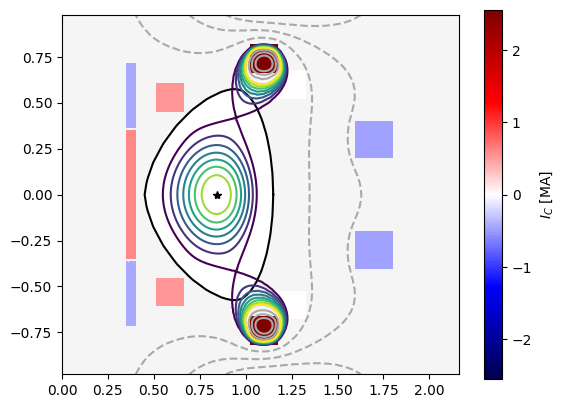

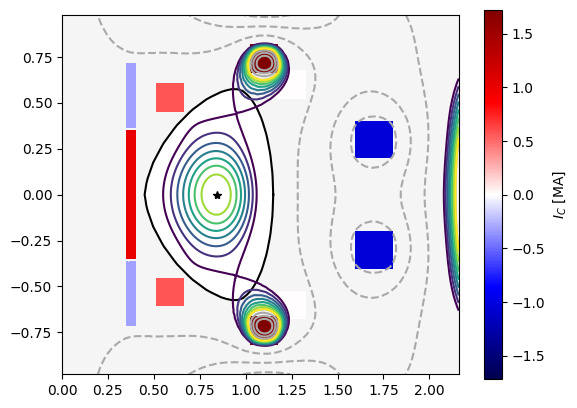

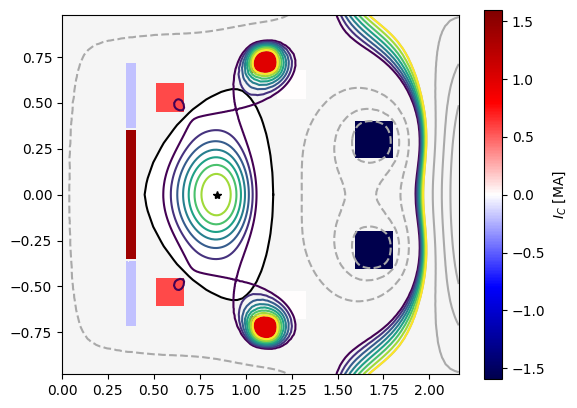

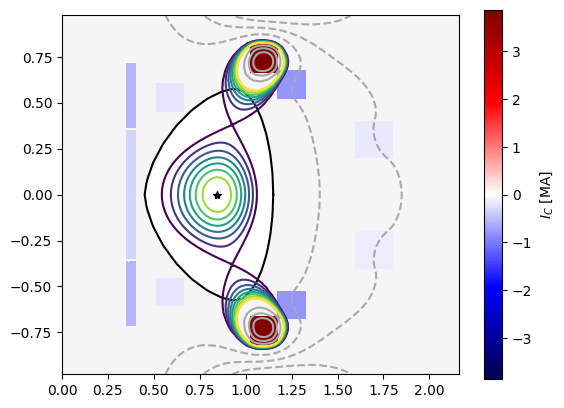

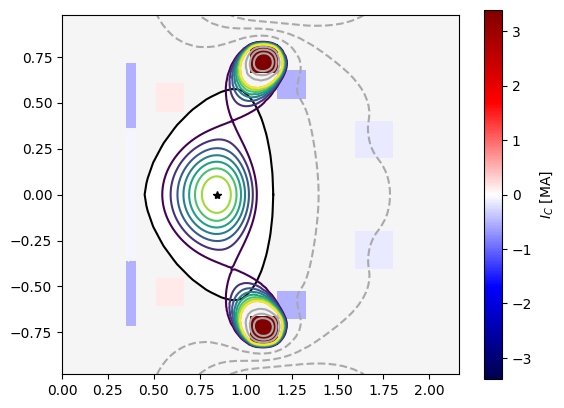

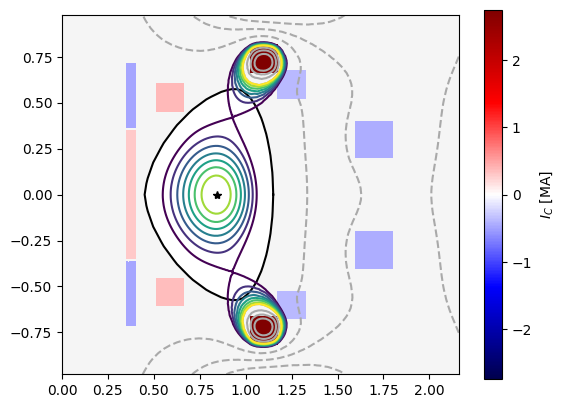

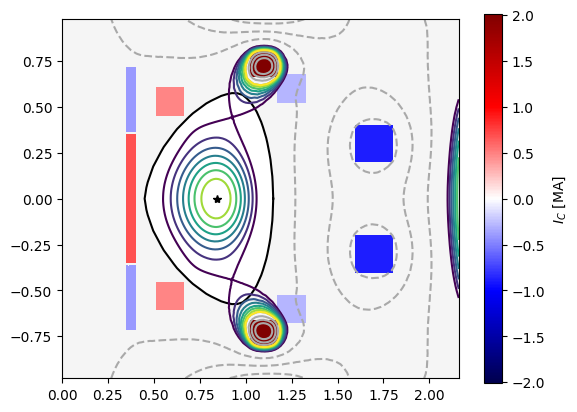

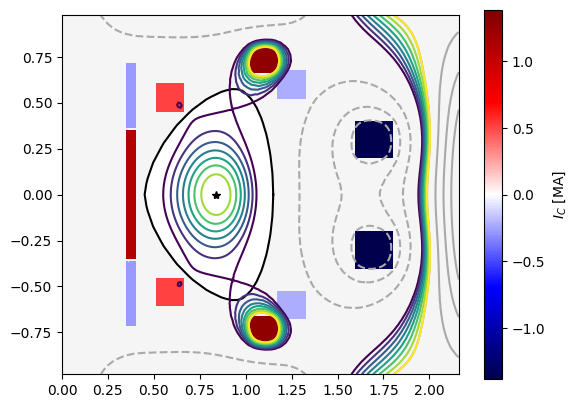

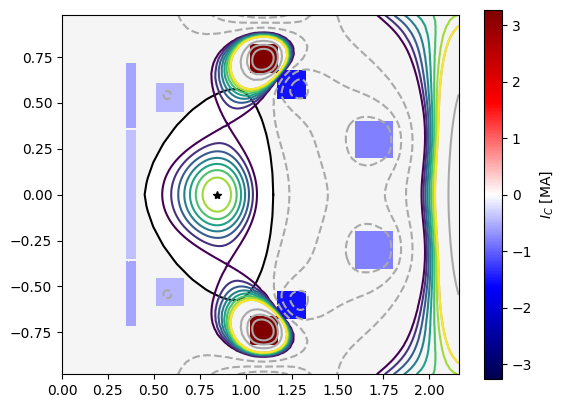

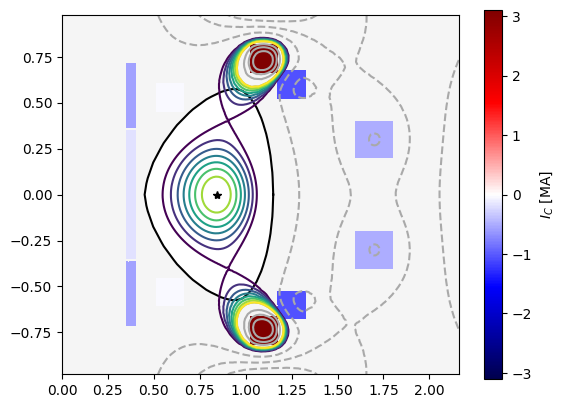

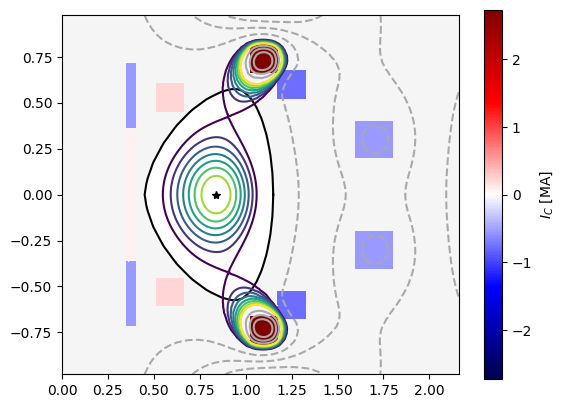

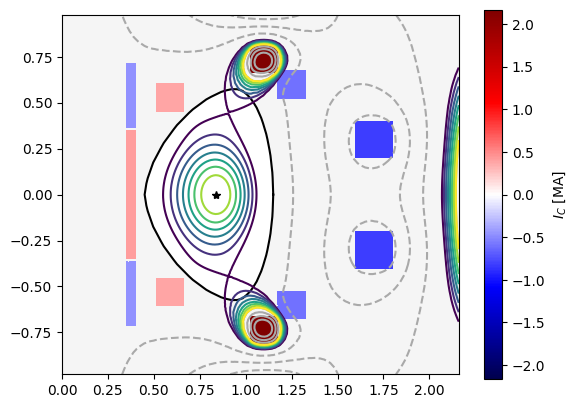

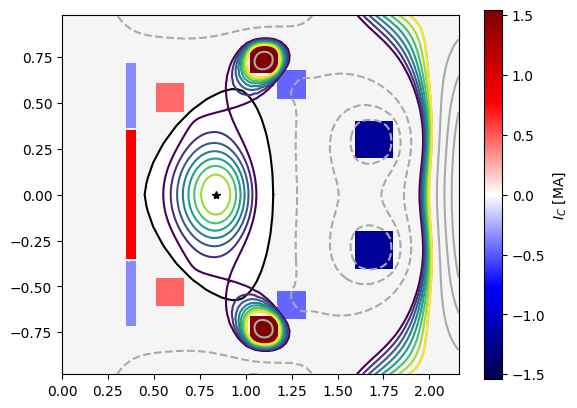

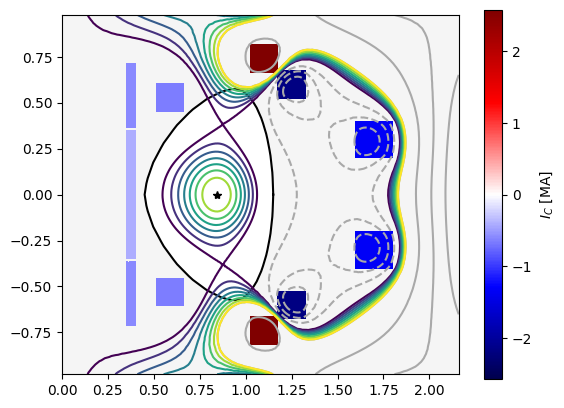

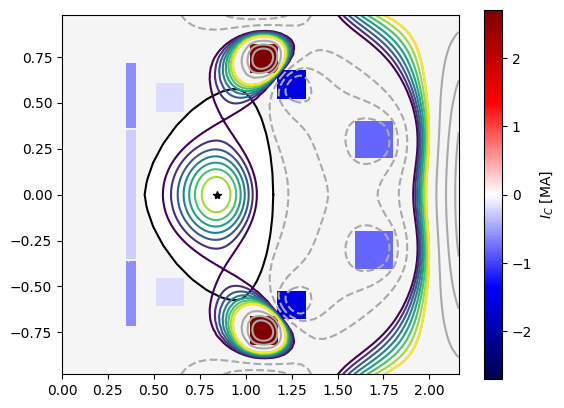

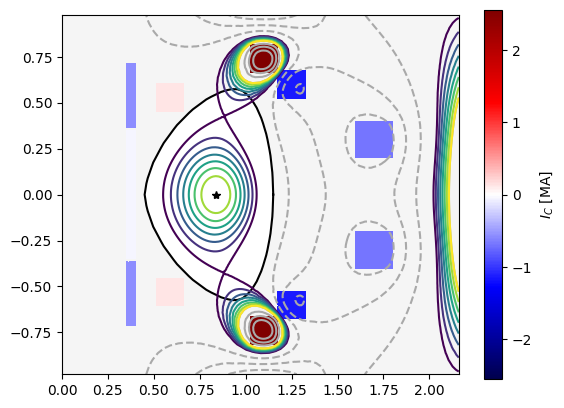

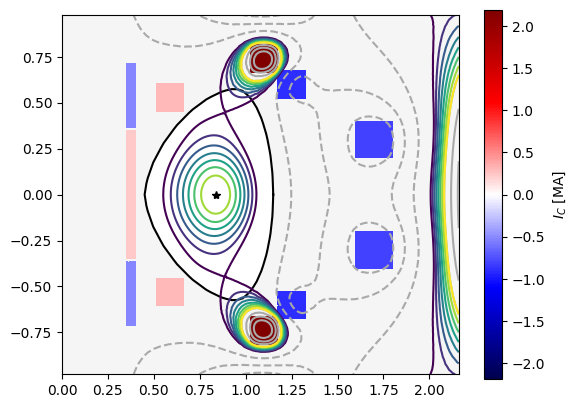

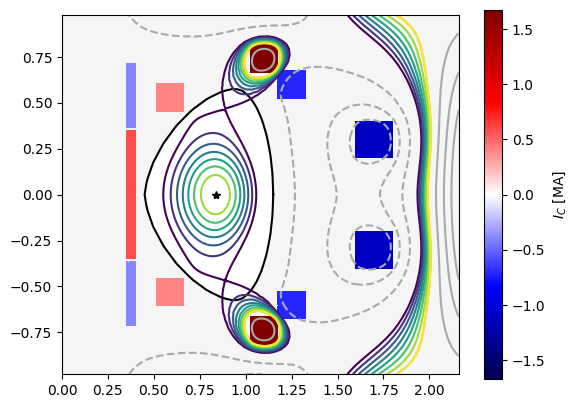

In [10]:
d_omfit = []
e_omfit = []
d_tok = []
e_tok = []
q95 = []
betap = []
li = []
currents = []
ds = np.linspace(-0.7, -.3, 5)
es = np.linspace(1.5, 1.9, 5)

for d in ds: 
    for e in es:
        mygs = TokaMaker()
        mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
        mygs.setup_regions(cond_dict=cond_dict)
        mygs.setup(order = 2, F0 =0.8*3) ## F0 = B0 * R0

        coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
        targets = np.zeros(mygs.ncoils+1)
        coil_weights = 0.5*np.ones(mygs.ncoils+1)

        #Set target values for CS coils
        coil_reg_mat[0,0] = 1
        coil_reg_mat[1,1] = 1
        coil_reg_mat[2,2] = 1
        targets[0] = -5E5
        targets[1] = -5E5 
        targets[2] = -5E5

        #Enforce up/down symmetry in PF coils
        coil_reg_mat[3,3] = 1
        coil_reg_mat[3,7] = -1
        coil_reg_mat[4,4] = 1
        coil_reg_mat[4,8] = -1
        coil_reg_mat[5,5] = 1
        coil_reg_mat[5,9] = -1
        coil_reg_mat[6,6] = 1
        coil_reg_mat[6,10] = -1

        mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

        #Set upper bound on coil currents
        coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
        coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
        mygs.set_coil_bounds(coil_bounds)

        # Define shape of P' anf FF' profiles

        n_sample = 40
        psi_sample = np.linspace(0.0,1.0,n_sample)

        # Set F*F' profile
        alpha = 2
        gamma = 3
        ffp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

        # Set P' profile
        alpha = 2
        gamma = 3
        pp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

        mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)


        Ip_target = 1E6
        mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

        
        r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.8, zoffset = 0, upnull = True, lonull = True, npts = 8)
        boundary = np.column_stack((r,z))
        x_points = np.zeros((2,2))
        x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
        x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]

        x_weights = 5*np.ones(2)
        mygs.set_saddles(x_points, x_weights)
        isoflux_weights = 30*np.ones(32)
        mygs.set_isoflux(boundary, isoflux_weights)

        mygs.init_psi(0.68,0,0.2, 1.8,0.3)
        mygs.settings.maxits = 100
        mygs.update_settings()
        mygs.solve()

        fig, ax = plt.subplots(1,1)
        mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
        mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)

        mygs.save_eqdsk('temp', lcfs_pad = .001, nr = 600, nz = 600)
        eqdsk = read_eqdsk('temp')
        rs = eqdsk['rzout'][:,0]
        zs = eqdsk['rzout'][:,1]

        eqdsk = OMFITgeqdsk('temp')
        d_omfit.append(eqdsk['fluxSurfaces']['geo']['delta'][-1])    
        e_omfit.append(eqdsk['fluxSurfaces']['geo']['kap'][-1])
        stats = mygs.get_stats()
        q95.append(stats['q_95'])
        betap.append(stats['beta_pol'])
        li.append(stats['l_i'])
        d_tok.append(stats['delta'])
        e_tok.append(stats['kappa'])

        current,currentmap = mygs.get_coil_currents()
        currents.append(current)
        

        mygs.reset()
    

    



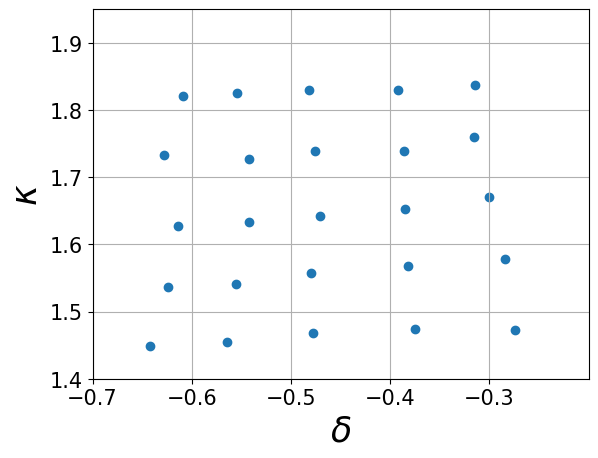

In [11]:
plt.scatter(d_omfit, e_omfit)
plt.xlabel(r'$\delta$', size = 25)
plt.ylabel(r'$\kappa$', size = 25)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()

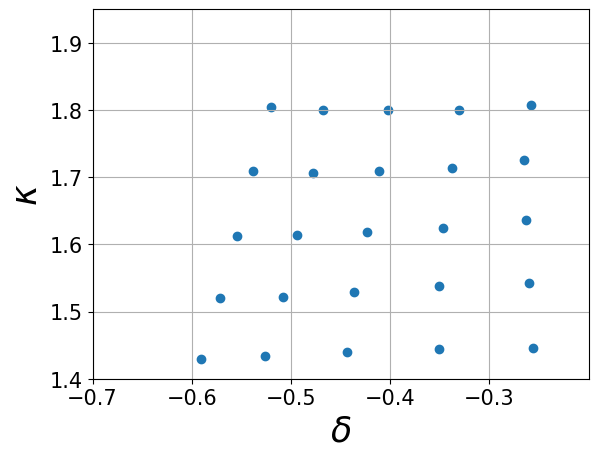

In [12]:
plt.scatter(d_tok, e_tok)
plt.xlabel(r'$\delta$', size = 25)
plt.ylabel(r'$\kappa$', size = 25)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()

In [15]:
print(d_omfit)

[-0.6424109267265934, -0.6239203586674844, -0.6138597162382351, -0.6274675546265038, -0.6092382852542331, -0.5649107710564639, -0.5555097984494505, -0.5423586030307258, -0.5426717389810607, -0.554064779631988, -0.4778700926941143, -0.4793356877643987, -0.47081671049957197, -0.4758729760474253, -0.48169623215692103, -0.37459515784749664, -0.3819322178536195, -0.38544209656310874, -0.3862032408641147, -0.3920328217689625, -0.2738146705805322, -0.28405020360762095, -0.3004071287989587, -0.31503518842348455, -0.3148841309303245]


In [14]:
print(currents[22])
print(d_omfit[22])
print(e_omfit[22])

[ -578380.18831371   -59043.85562906  -576194.75284411   126943.7970352
  2558250.23589021 -1143695.46412015  -681850.60766055   127907.72586121
  2557046.70383206 -1145246.01386597  -681655.47516642]
-0.3004071287989587
1.6708683519624148
